Reference: https://www.tensorflow.org/tutorials/load_data/images#create_a_dataset

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [2]:
batchSize = 16 # 64
imgHeight = 199
imgWidth = 199

# dataPath = "datasets/food-101/food-101/images/"
dataPath = "FastFood"

trainDataset = tf.keras.utils.image_dataset_from_directory(
  dataPath,
  validation_split=0.2,
  subset="training",
  color_mode = "rgb", 
  shuffle = True,
  seed=123,
  image_size=(imgHeight, imgWidth),
  batch_size=batchSize)

valDataset = tf.keras.utils.image_dataset_from_directory(
  dataPath,
  validation_split=0.2,
  subset="validation",
  color_mode = "rgb",
  shuffle = True,
  seed=123,
  image_size=(imgHeight, imgWidth),
  batch_size=batchSize)




Found 7000 files belonging to 7 classes.
Using 5600 files for training.
Found 7000 files belonging to 7 classes.
Using 1400 files for validation.


In [3]:
valBatch = tf.data.experimental.cardinality(valDataset)
testDataset = valDataset.take((2*valBatch) // 3)
valDataset = valDataset.skip((2*valBatch) // 3)

In [4]:
df = pd.read_csv('datasets/nutrition101 cut.csv')
protein_labels = list(df['protein'])
name_labels = list(df['name'])

In [5]:
def regression_dataset(data_list):
    def convt_labels(imgs, label):
        def convert_label(label):
            return np.array([data_list[int(y_i)] for y_i in label.numpy()])
        numeric_label = tf.py_function(convert_label, [label], tf.int32)
        return imgs, numeric_label
    return convt_labels

In [6]:
trainDataset = trainDataset.map(regression_dataset(protein_labels))
testDataset = testDataset.map(regression_dataset(protein_labels))
valDataset = valDataset.map(regression_dataset(protein_labels))

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

trainDataset = trainDataset.cache().prefetch(buffer_size=AUTOTUNE)
valDataset = valDataset.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
numClasses = 101

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),


  InceptionV3(weights="imagenet", include_top=False),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(1024, activation="sigmoid"),
  tf.keras.layers.Dense(128, activation="relu"),
  tf.keras.layers.Dropout(0.2),

  # tf.keras.layers.Conv2D(32, 11, activation='relu'),
  # tf.keras.layers.BatchNormalization(),
  # tf.keras.layers.MaxPooling2D(),

  # tf.keras.layers.Conv2D(32, 5, activation='relu'),
  # tf.keras.layers.BatchNormalization(),
  # tf.keras.layers.MaxPooling2D(),

  # tf.keras.layers.Conv2D(64, 3, activation='relu'),
  # tf.keras.layers.BatchNormalization(),
  # tf.keras.layers.MaxPooling2D(),

  # tf.keras.layers.Conv2D(64, 3, activation='relu'),
  # tf.keras.layers.BatchNormalization(),
  # tf.keras.layers.MaxPooling2D(),


  # tf.keras.layers.Dropout(0.7),

  # tf.keras.layers.Flatten(),
  
  # tf.keras.layers.Dense(514, activation='sigmoid'),
  # tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l1_l2(0.005))
])

In [9]:
learningRate = 0.0001

model.compile(
  optimizer=tf.keras.optimizers.RMSprop(learning_rate=learningRate,
    rho=0.9,
    momentum=0.1,
    epsilon=1e-07,
    centered=True
  ),
  loss=tf.keras.losses.MSE,
  metrics=['mse', 'mae'])

In [10]:
history = model.fit(
  trainDataset,
  validation_data=valDataset,
  epochs=50,
  callbacks=[tf.keras.callbacks.ModelCheckpoint(filepath="bestInceptionRegv3FF.h5", verbose=1, save_best_only=True)]
)

Epoch 1/50
350/350 [==============================] - ETA: 0s - loss: 20.2096 - mse: 20.1462 - mae: 3.2658
Epoch 1: val_loss improved from inf to 11.41870, saving model to bestInceptionRegv3FF.h5
350/350 [==============================] - 87s 191ms/step - loss: 20.2096 - mse: 20.1462 - mae: 3.2658 - val_loss: 11.4187 - val_mse: 11.8114 - val_mae: 2.1981
Epoch 2/50
350/350 [==============================] - ETA: 0s - loss: 8.8324 - mse: 8.7861 - mae: 2.0293
Epoch 2: val_loss improved from 11.41870 to 10.10393, saving model to bestInceptionRegv3FF.h5
350/350 [==============================] - 61s 175ms/step - loss: 8.8324 - mse: 8.7861 - mae: 2.0293 - val_loss: 10.1039 - val_mse: 10.3827 - val_mae: 1.7933
Epoch 3/50
350/350 [==============================] - ETA: 0s - loss: 5.9584 - mse: 5.9145 - mae: 1.5963
Epoch 3: val_loss did not improve from 10.10393
350/350 [==============================] - 59s 167ms/step - loss: 5.9584 - mse: 5.9145 - mae: 1.5963 - val_loss: 13.7413 - val_mse: 14

In [11]:
y_pred = model.predict(testDataset)
print(y_pred)
print(model.evaluate(testDataset))

58/58 [==============================] - 12s 101ms/step
[[ 8.603088 ]
 [14.87317  ]
 [14.678384 ]
 [24.721334 ]
 [16.799608 ]
 [ 7.7652316]
 [15.802965 ]
 [15.809945 ]
 [15.821909 ]
 [ 8.676751 ]
 [24.746702 ]
 [17.64878  ]
 [14.852414 ]
 [ 3.8713534]
 [ 8.717708 ]
 [14.759239 ]
 [16.536333 ]
 [ 7.6928673]
 [ 7.8027864]
 [16.510714 ]
 [15.145974 ]
 [14.13702  ]
 [17.56804  ]
 [14.8562355]
 [14.846438 ]
 [17.490065 ]
 [ 3.936786 ]
 [15.845351 ]
 [17.664345 ]
 [17.64694  ]
 [ 8.756347 ]
 [ 8.60481  ]
 [24.754013 ]
 [ 8.745748 ]
 [ 5.8096733]
 [17.538681 ]
 [ 7.874066 ]
 [15.818687 ]
 [ 4.0586567]
 [ 8.694241 ]
 [17.584349 ]
 [19.787426 ]
 [ 8.664678 ]
 [17.315056 ]
 [17.53375  ]
 [ 3.9282265]
 [ 4.704359 ]
 [17.194204 ]
 [ 8.3230915]
 [ 8.713027 ]
 [15.816433 ]
 [24.73261  ]
 [17.63853  ]
 [ 7.854297 ]
 [17.593864 ]
 [ 7.9283304]
 [17.549772 ]
 [14.988311 ]
 [14.734178 ]
 [ 3.9494364]
 [17.643219 ]
 [24.736834 ]
 [17.202724 ]
 [15.695341 ]
 [ 8.691524 ]
 [17.587893 ]
 [15.96779  ]
 [ 3.9

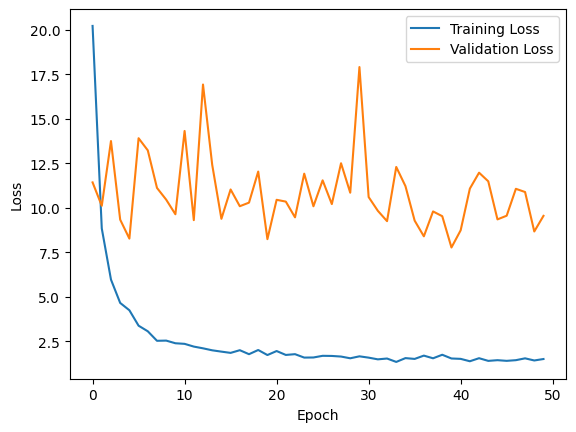

In [12]:
# Plot training and validation loss curves
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
model.save_weights("inceptionRegv3FF.h5")

In [16]:
loaded_model = tf.keras.models.load_model(r"BestRegressionWeights\proteinBestInceptionRegv3FF.h5")
pred = [x[0] for x in loaded_model.predict(testDataset)]
truth = np.array([y for x,y in testDataset]).reshape(-1)

58/58 [==============================] - 6s 66ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


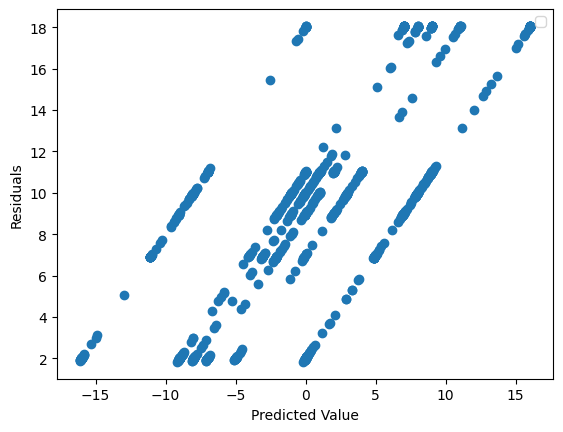

In [18]:
import matplotlib.pyplot as plt
plt.scatter(pred - truth, pred)
plt.xlabel('Predicted Value')
plt.ylabel('Residuals')
plt.show()